# SyriaTel Customer Churn Analysis

- An analysis of customer churn data using classification methods including: Logistic Regression, Decision Tree, and Random Forest models.

## Business Problem

SyriaTel, a telecommunications company, is interested in knowing the important factors in determining whether or not a customer will stay with the company. The primary goal of this notebook is to help SyriaTel keep current customers and offer business strategies on how to do so based on the analysis provided. 

Using customer account data, this notebook will analyze what features from the data are most important in prediciting customer churn, or whether or not they will leave the company. In order to do this the notebook will provide classification models aimed at producing the highest possible precision metric. Precsison was chosen as the primary metric based on the fact that it is the correct percentage of all the postive predictions. Because prediciting 'true' churn is the primary goal of the models this metric would make the most sense. Another metric that will also be taken into consideration as the secondary evaluation metric is area under the curve or AUC. This metric also seems relevant to the business problem due to the fact that a higher AUC score is correlated with better true positive predicitions, which is what we are after. 

Once the model with the highest precision and AUC score has been established we will then look at the coefficients/feature importances of the model in order to determine what factors were most important in producing the model. Using these coeffiecients, business strategies will then be provided as to how to increase profits by reducing churn among customers.   

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_graphviz, plot_tree
from IPython.display import Image
from sklearn import tree
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

## Functions

In [2]:
def countplot(X, title):
    """Takes in a dataframe and returns a countplot of the data."""
    sns.countplot(x=X, data=df)
    plt.title(title);

In [3]:
def countplot_hue(X, title, h):
    """Takes in a dataframe and returns a counplot with hue."""
    sns.countplot(x=X, data=df, hue=h)
    plt.title(title);

In [4]:
def coef_dict(model, features):
    """Returns a dictionary of coefficients for a model's features."""
    coef_dict_a = {}
    for coef, feat in zip(model.coef_[0,:], features.columns):
        coef_dict_a[feat] = coef
    return coef_dict_a

In [5]:
def plot_feature_imp(data, model, title, title_2):
    """Returns a barplot of a given model's feature importance."""
    feat_imps_df = pd.DataFrame(
    zip(data.columns, model.coef_[0,:]),
    columns=['Feature', 'Importance'],
    )
    
    fig, ax = plt.subplots(figsize=(12,8))
    sns.barplot(x='Importance', y='Feature', 
            data=feat_imps_df.sort_values(by='Importance', key=abs, ascending=False), orient='h', ax=ax)
    plt.suptitle(title_2, fontsize=18)
    plt.title(title);

In [6]:
def confusion_matrix(model, data, y, title):
    """Returns a confusion matrix of a given model."""
    plot_confusion_matrix(model, data, y, cmap='Greens')
    plt.title(title)
    plt.grid(False)

In [7]:
def classification(y, model, data):
    """Returns a classification report of a given model."""
    print(classification_report(y, model.predict(data)))

In [8]:
def plot_roc_curve(model, test_data, title):
    """Returns the ROC curve graph for a given model."""
    y_score = model.decision_function(test_data)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='green',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

In [9]:
def feature_dict(model, features):
    """Returns a dictionary of a given model's feature importance."""
    feature_dict = {}
    for coef, feat in zip(model.feature_importances_, features.columns):
        feature_dict[feat] = coef
    return feature_dict

In [10]:
def plot_feature_imp_2(data, model, title, title_2):
    """Returns a barplot of a given model's feature importance."""
    feat_imps_df = pd.DataFrame(
    zip(data.columns, model.feature_importances_),
    columns=['Feature', 'Importance'],
    )

    fig, ax = plt.subplots(figsize=(12,8))
    sns.barplot(x='Importance', y='Feature', 
            data=feat_imps_df.sort_values(by='Importance', key=abs, ascending=False), orient='h', ax=ax)
    plt.title(title)
    plt.suptitle(title_2, fontsize=18)

In [11]:
def plot_tree_auc_score(model, X_test, y_test, title):
    """Returns the ROC curve graph for a decision tree model."""
    y_pred = model.predict(X_test)
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='green',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

In [12]:
def plot_forest_features(train_df, model, title, title_2):
    """Returns a barplot of a random forest model's feature importance."""
    feat_imps_df = pd.DataFrame(
    zip(train_df.columns, model.feature_importances_),
    columns=['Feature', 'Importance'],
    )

    fig, ax = plt.subplots(figsize=(12,8))
    sns.barplot(x='Importance', y='Feature', 
            data=feat_imps_df.sort_values(by='Importance', ascending=False), orient='h', 
            ax=ax)
    plt.title(title)
    plt.suptitle(title_2, fontsize=18)

## Load Data

In [13]:
# Load dataset on SyriaTel customers' account information
df = pd.read_csv('Data/bigml_59c28831336c6604c800002a.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [14]:
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

## Data Description

The dataset contains relevant customer account data including:
  - The state the customer is from
    
  - The account length of the customer
    
  - the customer's area code
    
  - Whether or not the customer has an international plan
    
  - Whether or not the customer has a voicemail plan
    
  - The total day, evening, night, and international minutes of the customer
    
  - The total day, evening, night, and international calls of the customer
    
  - The total day, evening, night, and international charge of the customer
    
  - The total customer service calls of the customer
    
  - Whether or not the customer was 'true' or 'false' churn (true churn meaning that they have left the company, this will be the primary focus of the models)
  
  - The data appears to contain no missing values.

## Data Cleaning

In [16]:
# Update column names to include underscore
updated_columns = []
for c in df.columns:
    updated_columns.append(c.replace(' ', '_'))
df.columns = updated_columns
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

In [17]:
# Convert area_code column to object 
df['area_code'] = df.area_code.astype(object)

In [18]:
# Updated dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   object 
 3   phone_number            3333 non-null   object 
 4   international_plan      3333 non-null   object 
 5   voice_mail_plan         3333 non-null   object 
 6   number_vmail_messages   3333 non-null   int64  
 7   total_day_minutes       3333 non-null   float64
 8   total_day_calls         3333 non-null   int64  
 9   total_day_charge        3333 non-null   float64
 10  total_eve_minutes       3333 non-null   float64
 11  total_eve_calls         3333 non-null   int64  
 12  total_eve_charge        3333 non-null   float64
 13  total_night_minutes     3333 non-null   float64
 14  total_night_calls       3333 non-null   

## Data Exploration

In [19]:
plt.style.use('fivethirtyeight')

 - Will explore data to see if there are any noticible trends in order to make predictions.

In [20]:
# Check value counts for churn
df.churn.value_counts(normalize=True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

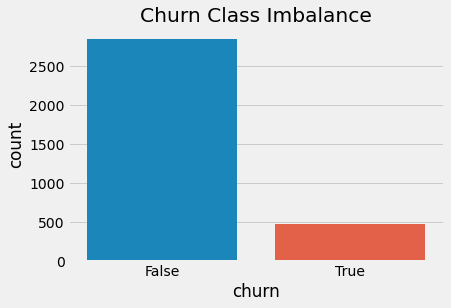

In [21]:
countplot('churn','Churn Class Imbalance')

 - Data contains significatly more 'false's then 'true's, this will need to be addressed later when building models in order to prevent class imbalance.

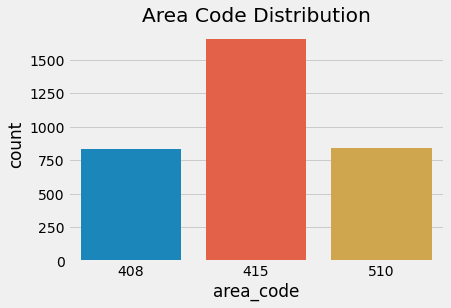

In [22]:
countplot('area_code','Area Code Distribution')

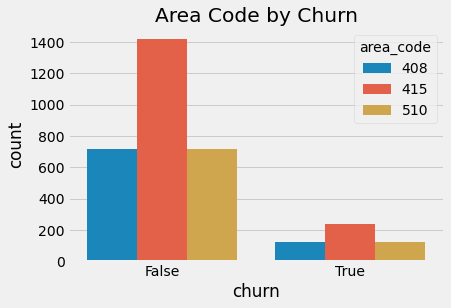

In [23]:
countplot_hue('churn', 'Area Code by Churn', 'area_code')

 - Area code only contains three different values, which appear evenly distributed across churn. Will likely drop this column. 

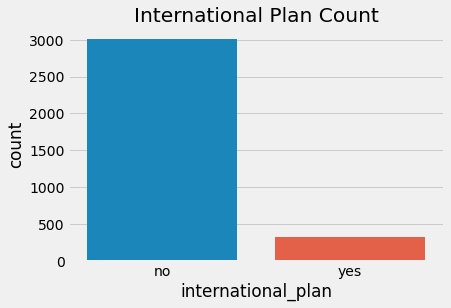

In [24]:
# Countplot for international_plan column
sns.countplot(x='international_plan', data=df).set(title='International Plan Count');

 - Internaional plan will need to be converted to a categorical feature.

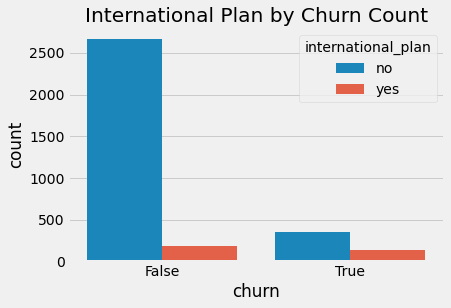

In [25]:
# Countplot showing distribution of international_plan by churn
sns.countplot(x='churn', hue='international_plan', data=df).set(title='International Plan by Churn Count');

 - It appears both categories contain a similar number of 'yes's despite the much greater number of False-churns from the data. This could be an idication that customers with True-churn are more likely to have an international plan. This could mean that international is a good predictor of churn.

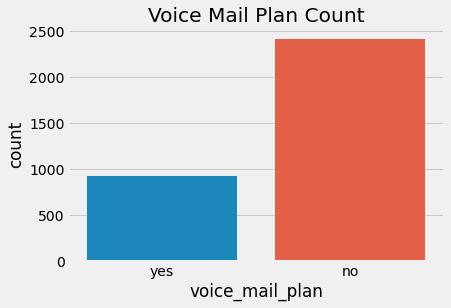

In [26]:
# Countplot of voice_mail_plan column
sns.countplot(x='voice_mail_plan', data=df).set(title='Voice Mail Plan Count');

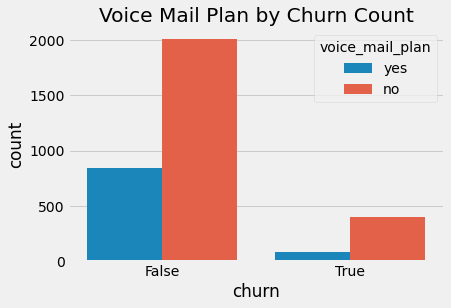

In [27]:
# Countplot showing distribution of voice_mail_plan by churn
sns.countplot(x='churn', hue='voice_mail_plan', data=df).set(title='Voice Mail Plan by Churn Count');

 - Voice mail plan appears to be similar across churn despite the unbalanced data, and is likely not a good predictor of churn.

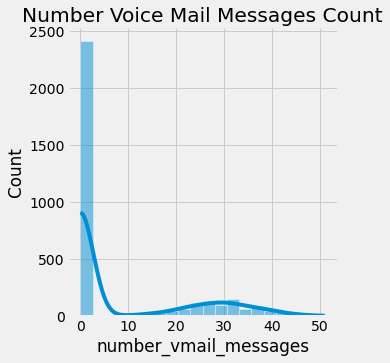

In [28]:
# Check distribution of number_vmail_messages column
sns.displot(x=df['number_vmail_messages'],kind='hist',kde=True).set(title='Number Voice Mail Messages Count');

 - Number vmail messages does not appear evenly distributed with a large portion of customers having 0 messages. This would make sense as many customers probably delete their voicemail messages and likely would not be a predicitor of churn.

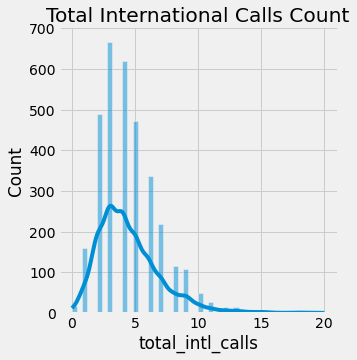

In [29]:
# Check distribution of total_intl_calls column
sns.displot(x=df['total_intl_calls'],kind='hist',kde=True).set(title='Total International Calls Count');

 - Total intl calls appears somewhat evenly distributed except for outliers over about 12. This would make sense as several customers are likely international customers making a lot of international calls. This likely would not have an effect on churn.

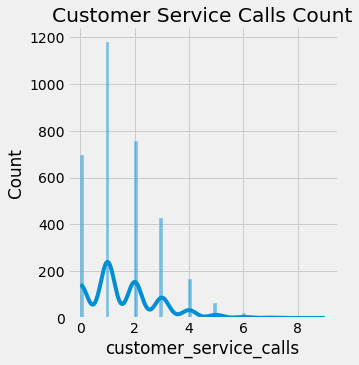

In [30]:
# Check distribution of customer_service_calls column
sns.displot(x=df['customer_service_calls'],kind='hist',kde=True).set(title='Customer Service Calls Count');

 - Customer service calls does not appear to be evenly distributed. This feature could be relevant at predicting churn as cutomers who are unhappy with their service would likely make more customer service calls.

## Pivot Table - Feature Averages

In [31]:
# Pivot table to check averages of columns across churn
pd.pivot_table(df, index='churn', values=df.columns)

,account_length,customer_service_calls,number_vmail_messages,total_day_calls,total_day_charge,total_day_minutes,total_eve_calls,total_eve_charge,total_eve_minutes,total_intl_calls,total_intl_charge,total_intl_minutes,total_night_calls,total_night_charge,total_night_minutes
churn,,,,,,,,,,,,,,,
False,100.793684,1.449825,8.604561,100.283158,29.780421,175.175754,100.038596,16.918909,199.043298,4.532982,2.743404,10.158877,100.058246,9.006074,200.133193
True,102.664596,2.229814,5.115942,101.335404,35.175921,206.914079,100.561077,18.054969,212.410145,4.163561,2.889545,10.700000,100.399586,9.235528,205.231677


 - Noticed higher average customer service calls for True-churn. This could be an indicator that as cusomter service calls increase so does churn.
 - Higher average number vmail messages for False-churn. Likely wouldn't expect this feature to have a great impact on churn.
 - Higher average charge and minutes for True-churn. This would make sense as customer with more minutes would accur a higher charge thus causing them look for a cheaper plan. 

## Check for Multicollinearity

In [32]:
df.corr()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
account_length,1.000000,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796,0.016541
number_vmail_messages,-0.004628,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263,-0.089728
total_day_minutes,0.006216,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423,0.205151
total_day_calls,0.038470,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942,0.018459
total_day_charge,0.006214,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427,0.205151
total_eve_minutes,-0.006757,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985,0.092796
total_eve_calls,0.019260,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423,0.009233
total_eve_charge,-0.006745,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987,0.092786
total_night_minutes,-0.008955,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288,0.035493
total_night_calls,-0.013176,0.007123,0.022972,-0.019557,0.022972,0.007586,0.007710,0.007596,0.011204,1.000000,0.011188,-0.013605,0.000305,-0.013630,-0.012802,0.006141


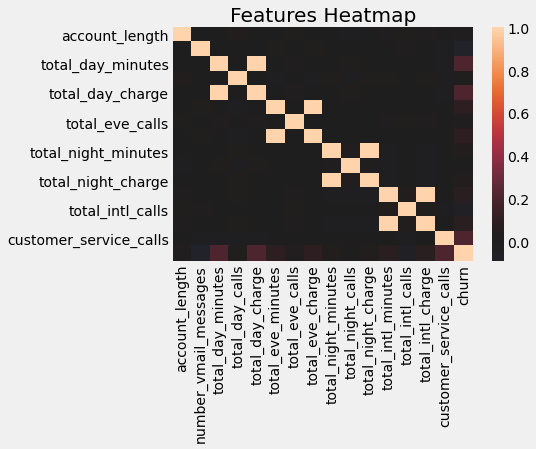

In [33]:
# Create heatmap to check for highly correlated features.
sns.heatmap(df.corr(), center=0).set(title='Features Heatmap');

 -  total_day_charge, total_day_calls, and total_day_minutes are highly correlated.

 - total_eve_charge, total_eve_calls, and total_eve_minutes are highly correlated.

 - total_night_charge, total_night_calls, and total_night_minutes are highly correlated.

 - total_intl_charge, total_intl_calls, and total_intl_minutes are highly correlated.
 
 > - Will need to seperate these features when building models to prevent multicollinearity.

## Drop Columns

In [34]:
# Drop area_code and phone_number from the data
df_filtered = df.drop(['area_code', 'phone_number'], axis=1)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   international_plan      3333 non-null   object 
 3   voice_mail_plan         3333 non-null   object 
 4   number_vmail_messages   3333 non-null   int64  
 5   total_day_minutes       3333 non-null   float64
 6   total_day_calls         3333 non-null   int64  
 7   total_day_charge        3333 non-null   float64
 8   total_eve_minutes       3333 non-null   float64
 9   total_eve_calls         3333 non-null   int64  
 10  total_eve_charge        3333 non-null   float64
 11  total_night_minutes     3333 non-null   float64
 12  total_night_calls       3333 non-null   int64  
 13  total_night_charge      3333 non-null   float64
 14  total_intl_minutes      3333 non-null   

 - Based on the analysis above I wouldn't expect either area code or phone number to very relevant in making any predictions regarding churn.

## Feature Engineering

In [35]:
# Create new feature adding together all 'charge' categories for a new 'total charge' column
total_charge = df_filtered['total_day_charge'] + df_filtered['total_eve_charge'] + df_filtered['total_night_charge'] + df_filtered['total_intl_charge']
df_filtered['total_charge'] = total_charge
df_filtered.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False,75.56
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False,59.24
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False,62.29
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False,66.80
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False,52.09


 - Based on the analysis from the pivot table above it seems customers with true-churn tend to have higher charges on their accounts. Adding all the charge categores together will create a new category of the total charge of the account. I would expect this feature to play a significant role in determing churn, as it would make sense that customers with higher total charges would be interested in pursuing a different wireless plan to reduce costs.

In [36]:
# Pivot tabel showing new 'total charge' feature with average total charge accross churn
pd.pivot_table(df_filtered, index='churn', values='total_charge')

,total_charge
churn,
False,58.448807
True,65.355963


 - As predicted higher the true-churn customers have a significantly higher total charge then the false-churn customers.

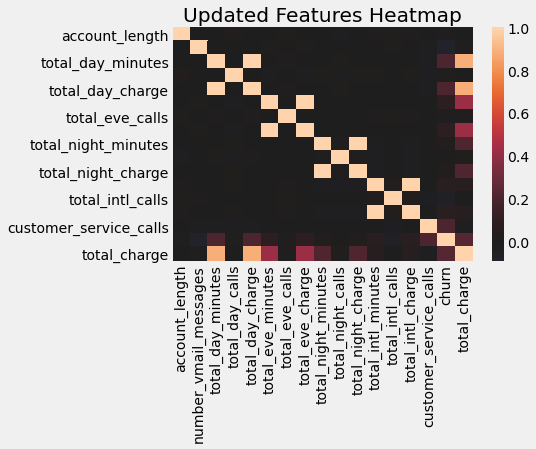

In [37]:
# Recheck heatmap with newly added 'total charge' feature
sns.heatmap(df_filtered.corr(), center=0).set(title='Updated Features Heatmap');

 - Based on the heatmap will need to seperate 'total charge' from 'total day minutes' and 'total day charge' in the models in order to prevent multicollinearity.  

## Data Exploration Summary

 - Based on the anaysis above, I would expect the following three features to play a fairly important role in predicting churn:
     
  - Total Charge
  - Customer Service Calls
  - Voice Mail Plan

## Split Data into Training and Testing sets

In [38]:
# Seperate data into X and y for analysis
X = df_filtered.drop(['churn'], axis=1)
y = df_filtered['churn']

In [39]:
# Perform train/test split on data in order to check for overfitting within the models
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [40]:
X_train.shape, y_train.shape

((2499, 19), (2499,))

In [41]:
X_test.shape, y_test.shape

((834, 19), (834,))

## Label Encoding

In [42]:
# Label encode y in order to make it a numeric value for easier model interpretation
labelencoder = LabelEncoder()

In [43]:
labelencoder.fit(y_train)
y_train = labelencoder.transform(y_train)

In [44]:
y_test = labelencoder.transform(y_test)

## Convert Categorical Features

In [45]:
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
ohe_train_df = pd.DataFrame(ohe.fit_transform(X_train[['international_plan', 'voice_mail_plan']]))
ohe_train_df.columns = ohe.get_feature_names(['international_plan', 'voice_mail_plan'])
X_train.drop(['international_plan', 'voice_mail_plan'] ,axis=1, inplace=True)
X_train = pd.concat([X_train.reset_index(drop=True),pd.DataFrame(ohe_train_df).reset_index(drop=True)], 
    axis=1)
X_train.head()

,state,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,...,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,total_charge,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes
0,MD,45,0,78.2,127,13.29,253.4,108,21.54,255.0,...,11.48,18.0,3,4.86,1,51.17,1.0,0.0,1.0,0.0
1,DE,115,0,195.9,111,33.30,227.0,108,19.30,313.2,...,14.09,13.2,1,3.56,2,70.25,1.0,0.0,1.0,0.0
2,OK,121,31,237.1,63,40.31,205.6,117,17.48,196.7,...,8.85,10.1,5,2.73,4,69.37,1.0,0.0,0.0,1.0
3,RI,180,0,143.3,134,24.36,180.5,113,15.34,184.2,...,8.29,10.1,4,2.73,1,50.72,1.0,0.0,1.0,0.0
4,OR,112,0,206.2,122,35.05,164.5,94,13.98,140.3,...,6.31,12.6,7,3.40,3,58.74,1.0,0.0,1.0,0.0


In [46]:
X_train.columns

Index(['state', 'account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',
       'total_charge', 'international_plan_no', 'international_plan_yes',
       'voice_mail_plan_no', 'voice_mail_plan_yes'],
      dtype='object')

In [47]:
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
ohe_test_df = pd.DataFrame(ohe.fit_transform(X_test[['international_plan', 'voice_mail_plan']]))
ohe_test_df.columns = ohe.get_feature_names(['international_plan', 'voice_mail_plan'])
X_test.drop(['international_plan', 'voice_mail_plan'] ,axis=1, inplace=True)
X_test = pd.concat([X_test.reset_index(drop=True),pd.DataFrame(ohe_test_df).reset_index(drop=True)], 
    axis=1)
X_test.head()

,state,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,...,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,total_charge,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes
0,WY,113,0,155.0,93,26.35,330.6,106,28.10,189.4,...,8.52,13.5,3,3.65,1,66.62,1.0,0.0,1.0,0.0
1,IL,67,0,109.1,117,18.55,217.4,124,18.48,188.4,...,8.48,12.8,6,3.46,0,48.97,1.0,0.0,1.0,0.0
2,SD,98,0,0.0,0,0.00,159.6,130,13.57,167.1,...,7.52,6.8,1,1.84,4,22.93,1.0,0.0,1.0,0.0
3,KY,147,0,212.8,79,36.18,204.1,91,17.35,156.2,...,7.03,10.2,2,2.75,1,63.31,1.0,0.0,1.0,0.0
4,WY,96,0,144.0,102,24.48,224.7,73,19.10,227.7,...,10.25,10.0,7,2.70,1,56.53,1.0,0.0,1.0,0.0


In [48]:
# Drop state column from the data 
X_train.drop(['state'], inplace=True, axis=1)

In [49]:
X_test.drop(['state'], inplace=True, axis=1)

# Modeling

 - Will create three different models including a Logistic Regression Model, a Decsison Tree, and a Random Forrest. Each model will contain a "vanilla model" without parameter tuning and will then run a Gridsearch to find the optimal parameters for each. The models will then be evaluated by precsision and AUC score as outlined earlier. The model with the highest precsion and auc score will then be analyzed by the coefficients in order to determine which features were most important in the model. Business recommendations will then be provided based on the model analysis.

## Model A - Logistic Regression Model (Vanilla Classifier)

### Model A Training

 - Will run a vanilla logistic regression model containing all features expect for highly correlated ones to get an idea of how the data perfroms.

### Feature Selection

In [50]:
X_train.columns

Index(['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',
       'total_charge', 'international_plan_no', 'international_plan_yes',
       'voice_mail_plan_no', 'voice_mail_plan_yes'],
      dtype='object')

In [51]:
features_train = pd.DataFrame(data=X_train, columns=['customer_service_calls','total_charge','number_vmail_messages',
                                            'account_length','total_eve_minutes','total_night_minutes',
                                            'total_intl_minutes','international_plan_no',
                                            'international_plan_yes','voice_mail_plan_no','voice_mail_plan_yes'])                                           

In [52]:
features_test = pd.DataFrame(data=X_test, columns=['customer_service_calls','total_charge','number_vmail_messages',
                                            'account_length','total_eve_minutes','total_night_minutes',
                                            'total_intl_minutes','international_plan_no',
                                            'international_plan_yes','voice_mail_plan_no','voice_mail_plan_yes'])

In [53]:
features_train.head()

,customer_service_calls,total_charge,number_vmail_messages,account_length,total_eve_minutes,total_night_minutes,total_intl_minutes,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes
0,1,51.17,0,45,253.4,255.0,18.0,1.0,0.0,1.0,0.0
1,2,70.25,0,115,227.0,313.2,13.2,1.0,0.0,1.0,0.0
2,4,69.37,31,121,205.6,196.7,10.1,1.0,0.0,0.0,1.0
3,1,50.72,0,180,180.5,184.2,10.1,1.0,0.0,1.0,0.0
4,3,58.74,0,112,164.5,140.3,12.6,1.0,0.0,1.0,0.0


In [54]:
features_test.head()

,customer_service_calls,total_charge,number_vmail_messages,account_length,total_eve_minutes,total_night_minutes,total_intl_minutes,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes
0,1,66.62,0,113,330.6,189.4,13.5,1.0,0.0,1.0,0.0
1,0,48.97,0,67,217.4,188.4,12.8,1.0,0.0,1.0,0.0
2,4,22.93,0,98,159.6,167.1,6.8,1.0,0.0,1.0,0.0
3,1,63.31,0,147,204.1,156.2,10.2,1.0,0.0,1.0,0.0
4,1,56.53,0,96,224.7,227.7,10.0,1.0,0.0,1.0,0.0


### Scale data

In [55]:
# Scale testing and training features
scale_features = StandardScaler()
scale_features.fit(features_train)
X_train_scaled = scale_features.transform(features_train)
X_test_scaled = scale_features.transform(features_test)

### Create Model

In [56]:
# Create vanilla logistic regression model, only changing class_weight to 'balanced' due to the highly imbalanced target data
model_a = LogisticRegression(class_weight='balanced')

In [57]:
# Fit model to training data
model_a.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced')

### Model A Evaluation Metrics

In [58]:
# Evaluate coefficients
coef_dict(model_a, features_train)

{'customer_service_calls': 0.7737536275703866,
 'total_charge': 0.7270736936760807,
 'number_vmail_messages': 0.2557707163911377,
 'account_length': 0.045890328160068695,
 'total_eve_minutes': -0.0023787644058909205,
 'total_night_minutes': 0.002828286526229075,
 'total_intl_minutes': 0.15425536133953013,
 'international_plan_no': -0.35844928975461987,
 'international_plan_yes': 0.35844928975462076,
 'voice_mail_plan_no': 0.3078747166557557,
 'voice_mail_plan_yes': -0.30787471665575694}

In [59]:
sns.set_palette('Paired')

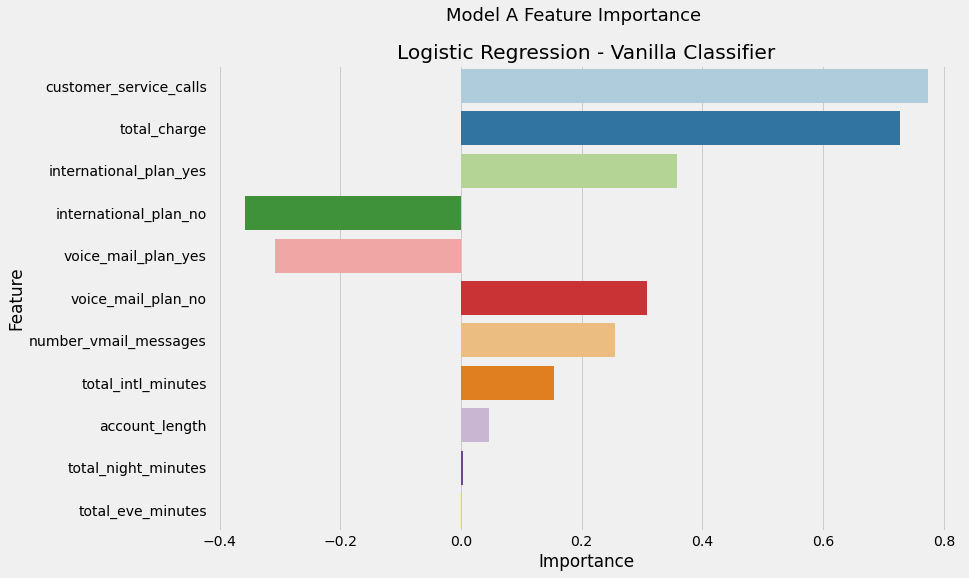

In [60]:
plot_feature_imp(features_train, model_a, 'Logistic Regression - Vanilla Classifier', 'Model A Feature Importance')

 - According to Model A, the top five most imortant features in predicting churn are:
 1. Customer Service Calls
 
 2. Total Charge
 
 3. International Plan
 
 4. Voice Mail Plan
 
 5. Number Voice Mail Messages

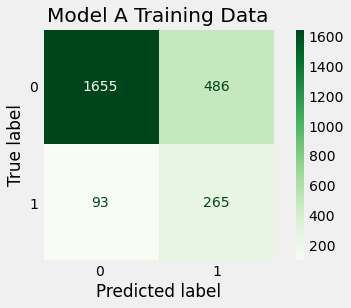

In [61]:
confusion_matrix(model_a, X_train_scaled, y_train, 'Model A Training Data')

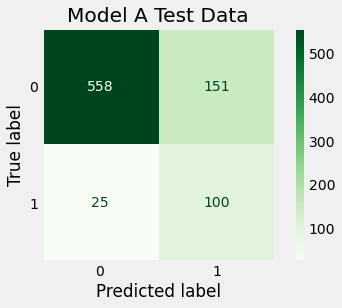

In [62]:
confusion_matrix(model_a, X_test_scaled, y_test, 'Model A Test Data')

 - According to the testing data confusion matrix, out of all the true positives, Model A predicts 100 out of 251 correctly. This would seem to indicate a low precsion score which should be reflected in the classification report. 

In [63]:
# Print model A classification report showing precision, recall, f1-score, and accuracy metrics
classification(y_train, model_a, X_train_scaled)

              precision    recall  f1-score   support

           0       0.95      0.77      0.85      2141
           1       0.35      0.74      0.48       358

    accuracy                           0.77      2499
   macro avg       0.65      0.76      0.66      2499
weighted avg       0.86      0.77      0.80      2499



In [64]:
# Model A testing data classification report
classification(y_test, model_a, X_test_scaled)

              precision    recall  f1-score   support

           0       0.96      0.79      0.86       709
           1       0.40      0.80      0.53       125

    accuracy                           0.79       834
   macro avg       0.68      0.79      0.70       834
weighted avg       0.87      0.79      0.81       834



 - According to the testing data classification report Model A shows a 40% precision score for true-churn. This would indicate a week model based on our main evaluation metric of precision.
 
 
 - Model A does not appear to be overfitting based on the similar results of metrics from the training and testing datasets.

AUC: 0.8377094499294782


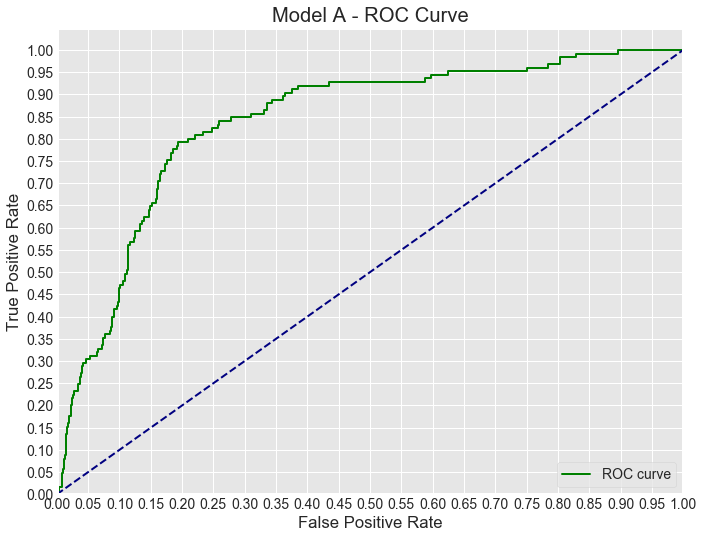

In [65]:
plot_roc_curve(model_a, X_test_scaled, 'Model A - ROC Curve')

### Model A Summary

 - Model A top features: 
 1. Customer Service Calls
 
 2. Total Charge
 
 3. International Plan
 
 4. Voice Mail Plan
 
 5. Number Voice Mail Messages
 
 - Precision Score (test data): 40%

 - Area under the curve (test data): 84%
 
 - Model does not appear to be overfitting.

## Model A2 - Logistic Regression (Tuned Parameters, Reduced Features)

 - Will run a second logistic regression model using tuned parameters from a gridsearch as well as reducing the features to the top five features from Model A. This will likely improve performance of the logistic regression model.

### Feature Selection

In [66]:
features_model_a2_train = pd.DataFrame(data=X_train, columns=['customer_service_calls','total_charge',
                                                             'international_plan_no',
                                            'international_plan_yes','voice_mail_plan_no','voice_mail_plan_yes'])

In [67]:
features_model_a2_test = pd.DataFrame(data=X_test, columns=['customer_service_calls','total_charge',
                                                             'international_plan_no',
                                            'international_plan_yes','voice_mail_plan_no','voice_mail_plan_yes'])

In [68]:
# Scale testing and training features for Model A2 features
scale_features_model_a2 = StandardScaler()
scale_features_model_a2.fit(features_model_a2_train)
X_train_scaled_a2 = scale_features_model_a2.transform(features_model_a2_train)
X_test_scaled_a2 = scale_features_model_a2.transform(features_model_a2_test)

### Parameter Tuning

 - Will tune the features of Model A using a gridsearch on the following parameters: 'penalty', 'C', 'solver', and 'max iter'. This should help in improving the overall model performance.

### GridsearchCV

In [69]:
# Select parameter options for gridsearchcv
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-3,3,7),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }]

In [70]:
# Create GridsearchCV classifier
clf = GridSearchCV(model_a, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [71]:
# Fit data and run GridsearchCV
best_clf = clf.fit(X_train_scaled_a2, y_train)

Fitting 3 folds for each of 560 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed:   11.9s finished


In [72]:
# Best classifer estimates
best_clf.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [73]:
# Create logistic regression model
model_a2 = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')

In [74]:
# Fit model to training data
model_a2.fit(X_train_scaled_a2, y_train)

LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')

In [75]:
# Evaluate coefficients
coef_dict(model_a2, features_model_a2_train)

{'customer_service_calls': 0.76620089674341,
 'total_charge': 0.7296453895876042,
 'international_plan_no': -0.18810759968602556,
 'international_plan_yes': 0.5421417506065935,
 'voice_mail_plan_no': 0.30252058047107766,
 'voice_mail_plan_yes': -0.06119314227011268}

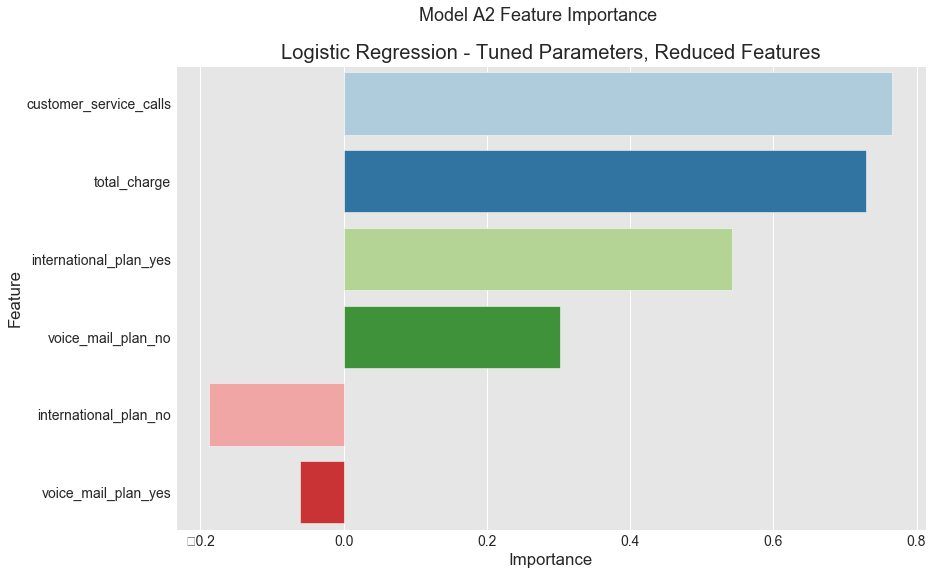

In [76]:
plot_feature_imp(features_model_a2_train, model_a2, 'Logistic Regression - Tuned Parameters, Reduced Features', 'Model A2 Feature Importance')

 - According to Model A2, the top three most imortant features in predicting churn are:
 1. Customer Service Calls
 
 2. Total Charge
 
 3. International Plan (no)

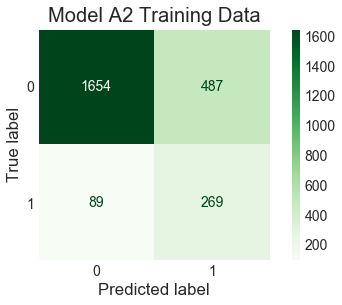

In [77]:
confusion_matrix(model_a2, X_train_scaled_a2, y_train, 'Model A2 Training Data')

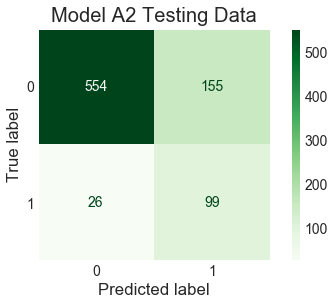

In [78]:
confusion_matrix(model_a2, X_test_scaled_a2, y_test, 'Model A2 Testing Data')

 - According to the testing data confusion matrix, out of all the true positives, Model A2 predicts 100 out of 156 correctly. This would seem to indicate a low precsion score which should be reflected in the classification report.

In [79]:
classification(y_train, model_a2, X_train_scaled_a2)

              precision    recall  f1-score   support

           0       0.95      0.77      0.85      2141
           1       0.36      0.75      0.48       358

    accuracy                           0.77      2499
   macro avg       0.65      0.76      0.67      2499
weighted avg       0.86      0.77      0.80      2499



In [80]:
classification(y_test, model_a2, X_test_scaled_a2)

              precision    recall  f1-score   support

           0       0.96      0.78      0.86       709
           1       0.39      0.79      0.52       125

    accuracy                           0.78       834
   macro avg       0.67      0.79      0.69       834
weighted avg       0.87      0.78      0.81       834



 - According to the testing data classification report Model A2 shows a 39% precision score for true-churn. This would indicate a week model based on our main evaluation metric of precision.
 
 
 - Model A2 does not appear to be overfitting based on the similar results of metrics from the training and testing datasets.

AUC: 0.837438645980254


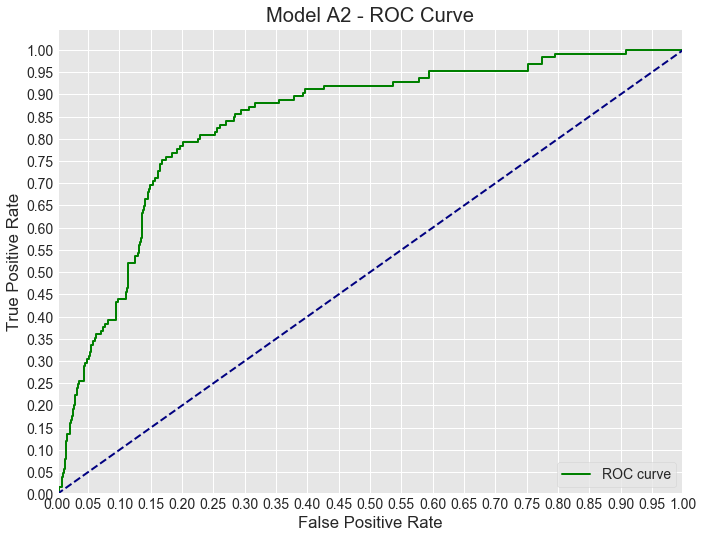

In [81]:
plot_roc_curve(model_a2, X_test_scaled_a2, 'Model A2 - ROC Curve')

### Model A2 Summary

 - Model A2 top features: 
 1. Customer Service Calls
 
 2. Total Charge
 
 3. International Plan (no)
 
 
 - Precision Score (test data): 39% (Down 1% from Model A

 - Area under the curve (test data): 84% (Same as Model A)
 
 - Model A2 does not appear to be overfitting.
 
 - Because reducing features did not improve precision score, will likely include all features from Model A in future models.

## Model B - Decision Tree (Vanilla Classifier)

In [82]:
# Create decision tree
model_b = DecisionTreeClassifier(random_state=42)  
model_b.fit(X_train_scaled, y_train) 

DecisionTreeClassifier(random_state=42)

In [83]:
# Calculate Model B feature importance
importance_b = model_b.feature_importances_

In [84]:
importance_b

array([0.12641627, 0.42757679, 0.12087814, 0.05847896, 0.04237531,
       0.04480285, 0.10107282, 0.06456016, 0.00767506, 0.00173886,
       0.00442478])

In [85]:
# List of features for Model B
features_train.columns

Index(['customer_service_calls', 'total_charge', 'number_vmail_messages',
       'account_length', 'total_eve_minutes', 'total_night_minutes',
       'total_intl_minutes', 'international_plan_no', 'international_plan_yes',
       'voice_mail_plan_no', 'voice_mail_plan_yes'],
      dtype='object')

In [86]:
feature_dict(model_b, features_train)

{'customer_service_calls': 0.12641626795803798,
 'total_charge': 0.42757679103314383,
 'number_vmail_messages': 0.12087813534174843,
 'account_length': 0.05847895565674867,
 'total_eve_minutes': 0.0423753092681692,
 'total_night_minutes': 0.04480284638072947,
 'total_intl_minutes': 0.10107282083257793,
 'international_plan_no': 0.06456016144372015,
 'international_plan_yes': 0.007675064857154304,
 'voice_mail_plan_no': 0.0017388626940368801,
 'voice_mail_plan_yes': 0.004424784533933133}

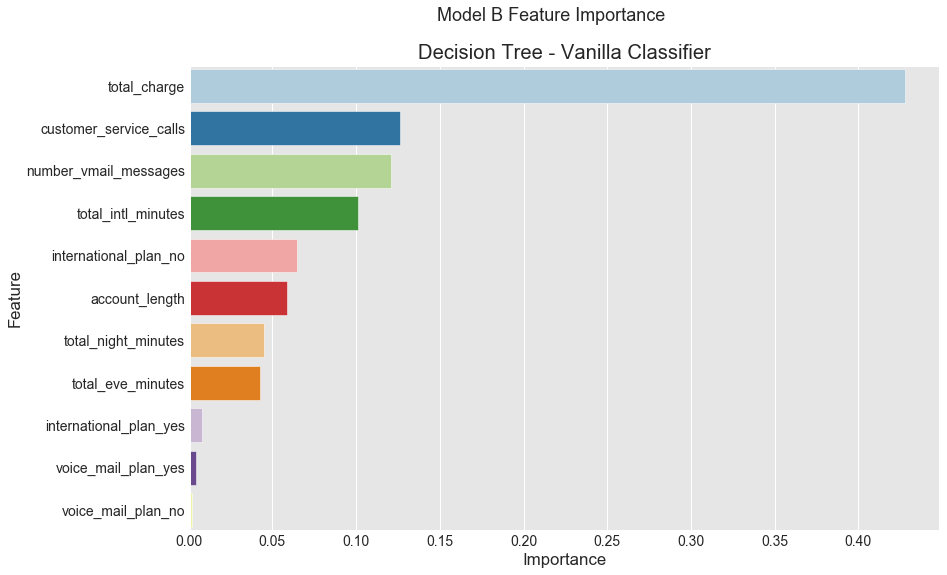

In [87]:
plot_feature_imp_2(features_train, model_b, 'Decision Tree - Vanilla Classifier', 'Model B Feature Importance')

In [88]:
# Check feature importance
for i,v in enumerate(importance_b):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.12642
Feature: 1, Score: 0.42758
Feature: 2, Score: 0.12088
Feature: 3, Score: 0.05848
Feature: 4, Score: 0.04238
Feature: 5, Score: 0.04480
Feature: 6, Score: 0.10107
Feature: 7, Score: 0.06456
Feature: 8, Score: 0.00768
Feature: 9, Score: 0.00174
Feature: 10, Score: 0.00442


 - According to Model B, the top five most imortant features in predicting churn are:
 1. Total Charge
 
 2. Customer Service Calls
 
 3. Number Voice Mail Messages
 
 4. Total International Minutes
 
 5. International plan (no)

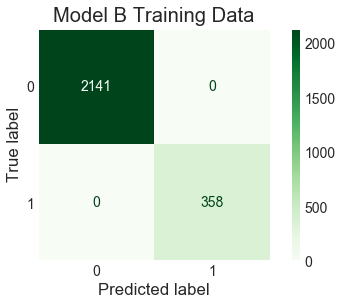

In [89]:
confusion_matrix(model_b, X_train_scaled, y_train, 'Model B Training Data')

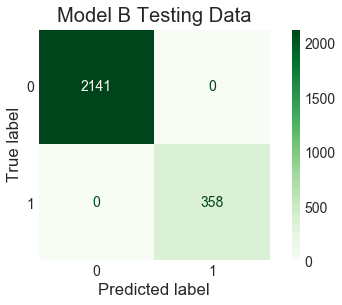

In [90]:
confusion_matrix(model_b, X_train_scaled, y_train, 'Model B Testing Data')

 - The training data confusion matrix predicts all of the predictions correctly. This would likely indicate that the model is overfitting the data and will need to tune the decision tree parameters for a more reliable model.

In [91]:
classification(y_train, model_b, X_train_scaled)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2141
           1       1.00      1.00      1.00       358

    accuracy                           1.00      2499
   macro avg       1.00      1.00      1.00      2499
weighted avg       1.00      1.00      1.00      2499



In [92]:
classification(y_test, model_b, X_test_scaled)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       709
           1       0.75      0.80      0.77       125

    accuracy                           0.93       834
   macro avg       0.86      0.88      0.87       834
weighted avg       0.93      0.93      0.93       834



 - According to the testing data classification report Model A shows a .75% precision score for true-churn compared to a 100% precision score on the training data.
 
 
 - Model B is overfitting based on these results

AUC: 0.8760225669957686


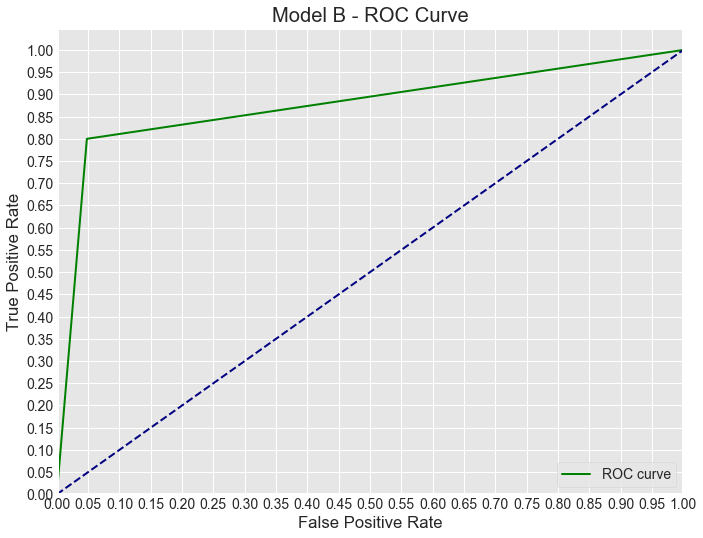

In [93]:
# Calculate AUC
plot_tree_auc_score(model_b, X_test_scaled, y_test, 'Model B - ROC Curve')

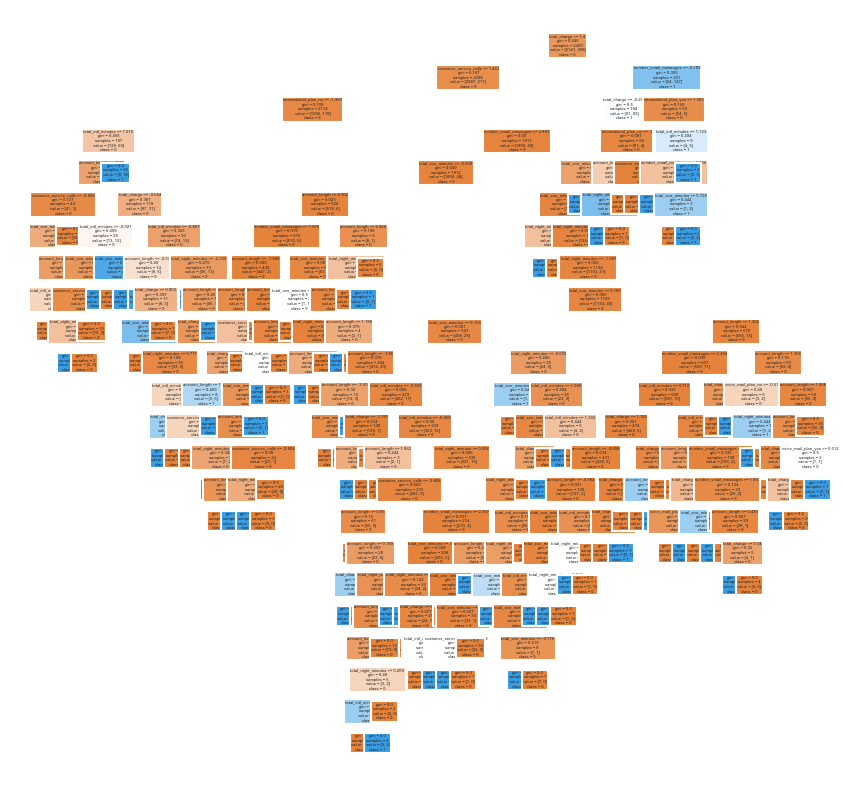

In [94]:
# Graph Model B decision tree
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
tree.plot_tree(model_b,
               feature_names = features_train.columns, 
               class_names=np.unique(y_train).astype('str'),
               filled = True)
plt.show()

 - Overly large and complex tree graph again confirms that Model B is overfitting the data and will need to tuned going forward

### Model B Summary

 - Model B top features: 
 1. Total Charge
 
 2. Customer Service Calls
 
 3. Number Voice Mail Messages
 
 4. Total International Minutes
 
 5. International plan (no)
 
 
 - Precision Score (test data): 100% (Up 61% from Model A2)

 - Area under the curve (test data): 88% (Up 4% from Model A2)
 
 - Model B is overfitting and parameters will need to adjusted going forward in order to produce a more reliable model.

## Model B2 - Decision Tree (Tuned Parameters)

### Parameter Tuning

In [95]:
# Select parameter options for gridsearchcv
param_grid_b2 = [    
    {'max_depth' : [1, 10, 10],
    'min_samples_split' : [1, 10, 10],
    'min_samples_leaf' : [0.1, 0.5, 5]
    }]

In [96]:
# Create GridsearchCV classifier
clf_b2 = GridSearchCV(model_b, param_grid = param_grid_b2, cv = 3, verbose=True, n_jobs=-1)

In [97]:
# Fit data and run GridsearchCV
best_clf_b2 = clf_b2.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    0.4s finished


In [98]:
# Best classifer estimates
best_clf_b2.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [99]:
# Create new decision tree model based on best classifier estimates
model_b2 = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)  
model_b2.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

### Check Feature Importance

In [100]:
# Create Model B2 feature importance
importance_b2 = model_b2.feature_importances_

In [101]:
feature_dict(model_b2, features_train)

{'customer_service_calls': 0.14363435037197136,
 'total_charge': 0.49875684674224097,
 'number_vmail_messages': 0.002364552571808968,
 'account_length': 0.00986192507230964,
 'total_eve_minutes': 0.005170695204261034,
 'total_night_minutes': 0.004985530992502395,
 'total_intl_minutes': 0.10048936319164639,
 'international_plan_no': 0.0911259076801379,
 'international_plan_yes': 0.0,
 'voice_mail_plan_no': 0.14361082817312143,
 'voice_mail_plan_yes': 0.0}

In [102]:
# Check Model B2 feature importance
for i,v in enumerate(importance_b2):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.14363
Feature: 1, Score: 0.49876
Feature: 2, Score: 0.00236
Feature: 3, Score: 0.00986
Feature: 4, Score: 0.00517
Feature: 5, Score: 0.00499
Feature: 6, Score: 0.10049
Feature: 7, Score: 0.09113
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.14361
Feature: 10, Score: 0.00000


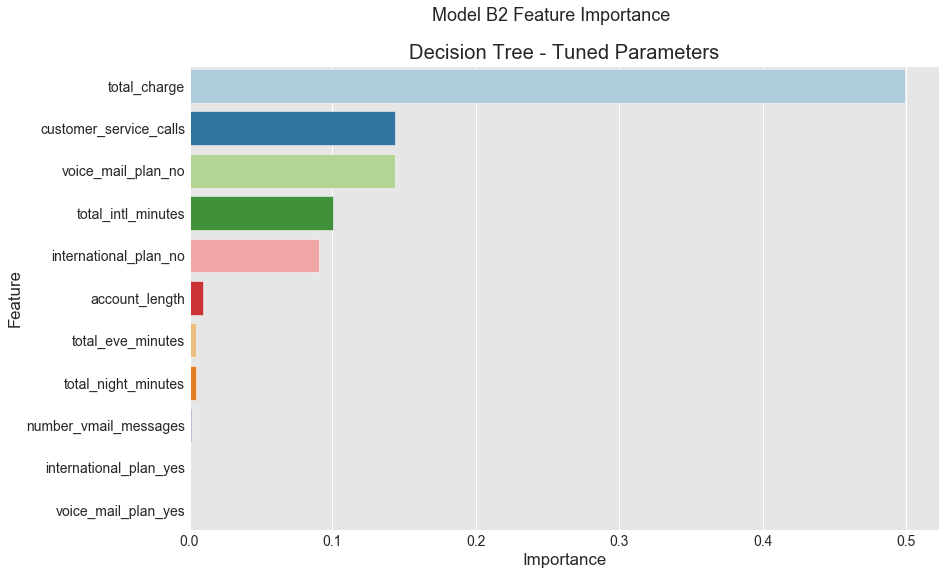

In [103]:
plot_feature_imp_2(features_train, model_b2, 'Decision Tree - Tuned Parameters', 'Model B2 Feature Importance')

 - According to Model B2, the top five most imortant features in predicting churn are:
 1. Total Charge
 
 2. Customer Service Calls
 
 3. Voice Mail plan (no)
 
 4. Total International Minutes
 
 5. International plan (no)

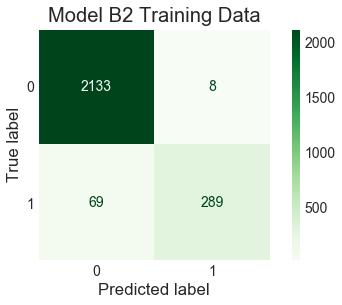

In [104]:
confusion_matrix(model_b2, X_train_scaled, y_train, 'Model B2 Training Data')

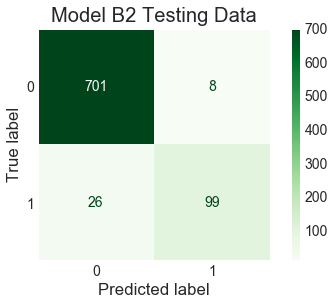

In [105]:
confusion_matrix(model_b2, X_test_scaled, y_test, 'Model B2 Testing Data')

 - According to the testing data confusion matrix, out of all the true positives, Model B2 predicts 99 out of 107 correctly. This would seem to indicate a high precsion score which should be reflected in the classification report.

In [106]:
# Training data classification report
classification(y_train, model_b2, X_train_scaled)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2141
           1       0.97      0.81      0.88       358

    accuracy                           0.97      2499
   macro avg       0.97      0.90      0.93      2499
weighted avg       0.97      0.97      0.97      2499



In [107]:
# Testing data classification report
classification(y_test, model_b2, X_test_scaled)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       709
           1       0.93      0.79      0.85       125

    accuracy                           0.96       834
   macro avg       0.94      0.89      0.91       834
weighted avg       0.96      0.96      0.96       834



 - According to the testing data classification report Model B2 shows a 93% precision score for true-churn. This would indicate a strong model based on our main evaluation metric of precision.
 
 
 - Model B2 does not appear to be overfitting based on the similar results of metrics from the training and testing datasets.

AUC: 0.8903582510578281


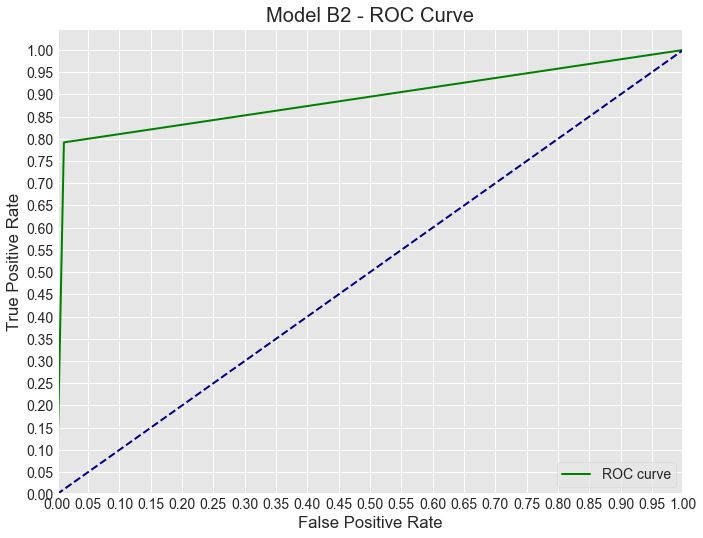

In [108]:
# Calculate AUC
plot_tree_auc_score(model_b2, X_test_scaled, y_test, 'Model B2 - ROC Curve')

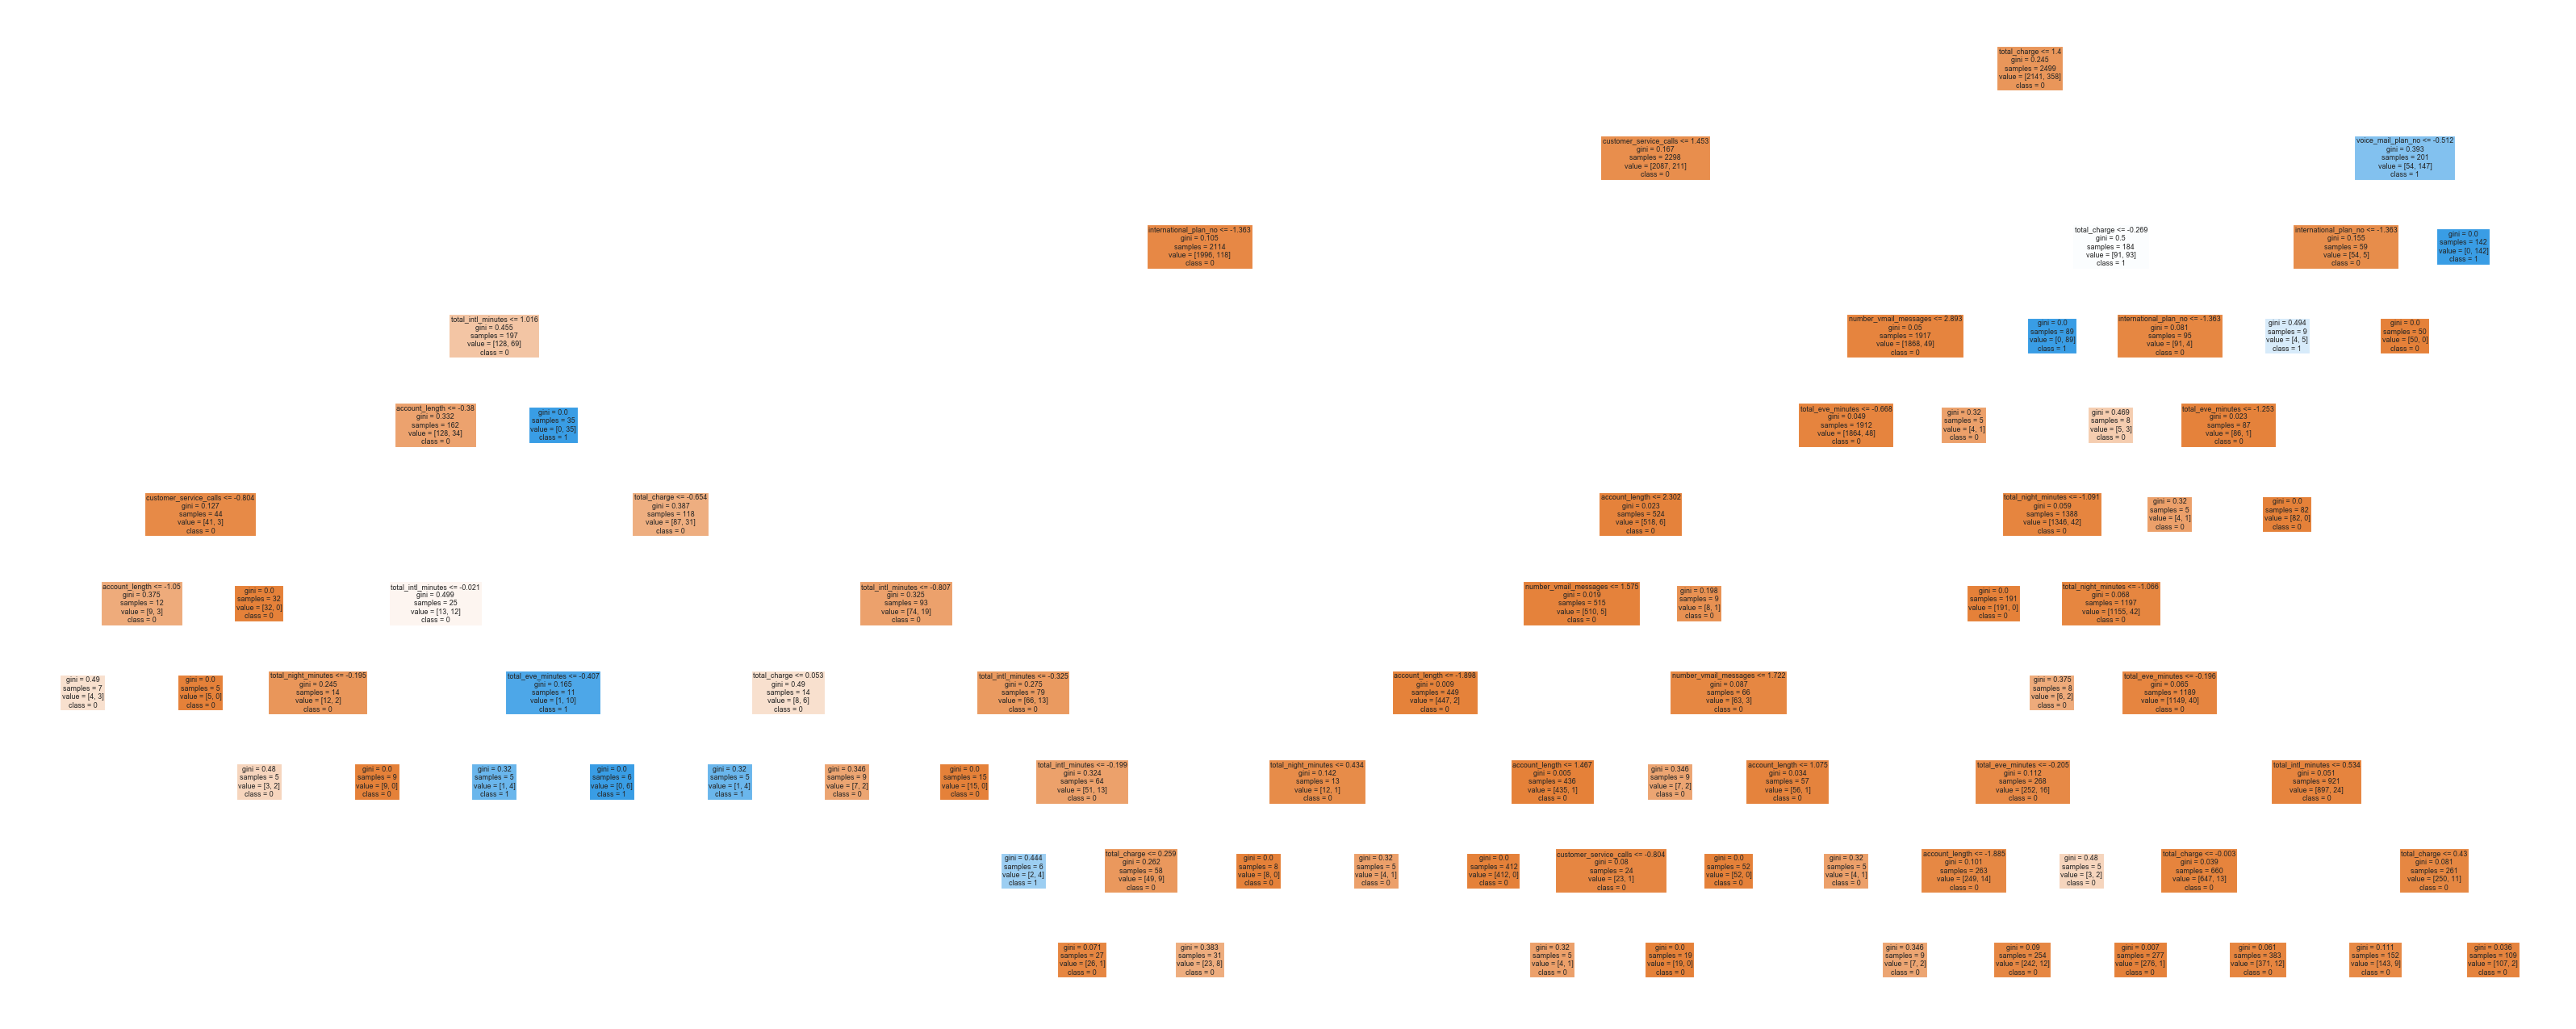

In [109]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (12,5), dpi=300)
tree.plot_tree(model_b2,
               feature_names = features_train.columns, 
               class_names=np.unique(y_train).astype('str'),
               filled = True)
plt.show()

### Model B2 Summary

 - Model B2 top features: 
 1. Total Charge
 
 2. Customer Service Calls
 
 3. Voice Mail plan (no)
 
 4. Total International Minutes
 
 5. International plan (no)
 
 - Precision Score (test data): 93% (Highest precision score so far)

 - Area under the curve (test data): 89% (Highest AUC score so far)
 
 - Model B2 does not appear to be overfitting based on similar training and testing results.

## Model C - Random Forest (Vanilla Classifier)

In [110]:
# Create Random Forest model
forest = RandomForestClassifier(random_state=42)
forest.fit(features_train, y_train)

RandomForestClassifier(random_state=42)

In [111]:
# Convert training features to dataframe
features_train_df = pd.DataFrame(features_train)

In [112]:
# Convert testing features to dataframe
features_test_df = pd.DataFrame(features_test)

In [113]:
features_train_df.columns

Index(['customer_service_calls', 'total_charge', 'number_vmail_messages',
       'account_length', 'total_eve_minutes', 'total_night_minutes',
       'total_intl_minutes', 'international_plan_no', 'international_plan_yes',
       'voice_mail_plan_no', 'voice_mail_plan_yes'],
      dtype='object')

In [114]:
# Check feature importance
forest.feature_importances_

array([0.14811093, 0.40745588, 0.03546481, 0.05858252, 0.07612397,
       0.06326214, 0.09346668, 0.04237877, 0.03477968, 0.01924587,
       0.02112877])

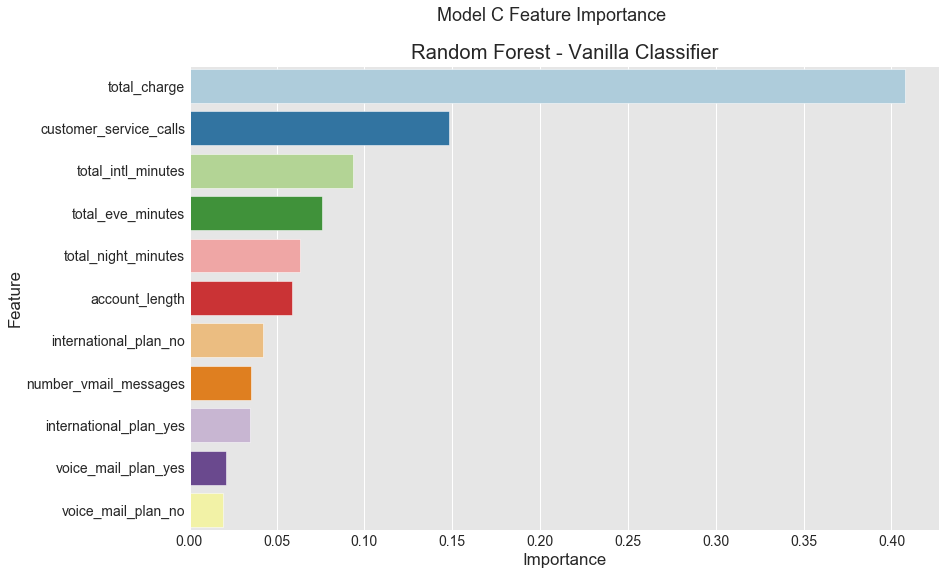

In [115]:
# Graph feature importance
plot_forest_features(features_train_df, forest, 'Random Forest - Vanilla Classifier', 'Model C Feature Importance')

 - According to Model C, the top five most imortant features in predicting churn are:
 1. Total Charge
 
 2. Customer Service Calls
 
 3. Total International Minutes
 
 4. Total Eve Minutes
 
 5. Total Night Minutes

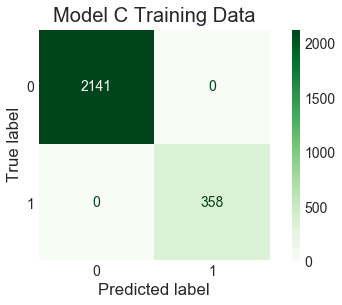

In [116]:
confusion_matrix(forest, features_train, y_train, 'Model C Training Data')

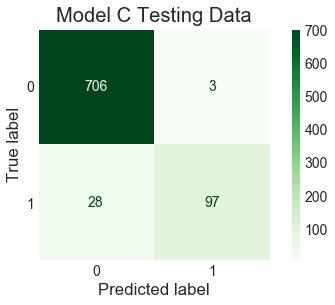

In [117]:
confusion_matrix(forest, features_test, y_test, 'Model C Testing Data')

In [118]:
# Model C training data classification report
classification(y_train, forest, features_train_df)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2141
           1       1.00      1.00      1.00       358

    accuracy                           1.00      2499
   macro avg       1.00      1.00      1.00      2499
weighted avg       1.00      1.00      1.00      2499



In [119]:
# Model C testing data classification report
classification(y_test, forest, features_test_df)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       709
           1       0.97      0.78      0.86       125

    accuracy                           0.96       834
   macro avg       0.97      0.89      0.92       834
weighted avg       0.96      0.96      0.96       834



 - According to the testing data classification report Model C shows a 97% precision score for true-churn. This would indicate a strong model based on our main evaluation metric of precision.
 
 
 - Model C appears to be overfitting based on the perfect results from the training data. Will need to tune parameters going forward.

In [120]:
y_pred_c = forest.predict(features_test) 

In [121]:
# Calculate Model C AUC
false_positive_rate_c, true_positive_rate_c, thresholds_c = roc_curve(y_test, y_pred_c)
roc_auc_c = auc(false_positive_rate_c, true_positive_rate_c)
print('\nAUC is :{0}'.format(round(roc_auc_c, 2)))


AUC is :0.89


### Model C Summary

 - Model B2 top features: 
 1. Total Charge
 
 2. Customer Service Calls
 
 3. Total International Minutes
 
 4. Total Eve Minutes
 
 5. Total Night Minutes
 
 - Precision Score (test data): 97% (Highest precision score so far)

 - Area under the curve (test data): 89% (Highest AUC score, tied with Model B2)
 
 - Model C appears to be overfitting based on perfect training data results

## Model C2 - Random Forest (Tuned Parameters)

### Parameter Tuning

In [122]:
# Select parameter options for gridsearchcv
param_grid_c = [    
    {'min_samples_leaf' : [1, 2, 4],
    'n_estimators' : [100, 200, 300],
    'min_samples_split' : [2, 5, 10],
     'max_depth' : [10, 20, 30, 40, 50]
    }]

In [123]:
# Create GridsearchCV classifier
clf_c = GridSearchCV(forest, param_grid = param_grid_c, cv = 3, verbose=True, n_jobs=-1)

In [124]:
# Fit data and run GridsearchCV
best_clf_c = clf_c.fit(features_train, y_train)

Fitting 3 folds for each of 135 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  2.2min finished


In [125]:
# Best classifer estimates
best_clf_c.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_leaf=4, n_estimators=200,
                       random_state=42)

In [126]:
forest_2 = RandomForestClassifier(max_depth=20, min_samples_leaf=4, n_estimators=200,
                       random_state=42)
forest_2.fit(features_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=4, n_estimators=200,
                       random_state=42)

In [127]:
features_train_df.columns

Index(['customer_service_calls', 'total_charge', 'number_vmail_messages',
       'account_length', 'total_eve_minutes', 'total_night_minutes',
       'total_intl_minutes', 'international_plan_no', 'international_plan_yes',
       'voice_mail_plan_no', 'voice_mail_plan_yes'],
      dtype='object')

In [128]:
forest_2.feature_importances_

array([0.1657091 , 0.44808536, 0.03366081, 0.03539438, 0.05044339,
       0.03828721, 0.07776943, 0.05543788, 0.04311214, 0.02392198,
       0.02817831])

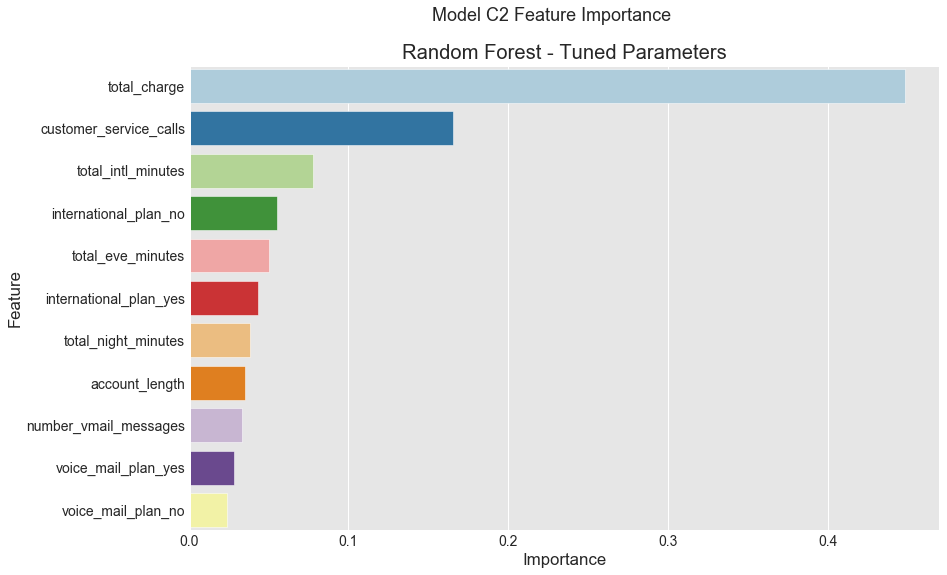

In [129]:
# Graph feature importance
plot_forest_features(features_train_df, forest_2, 'Random Forest - Tuned Parameters', 'Model C2 Feature Importance')

 - According to Model C, the top five most imortant features in predicting churn are:
 1. Total Charge
 
 2. Customer Service Calls
 
 3. Total International Minutes
 
 4. International Plan (no)
 
 5. Total Eve Minutes

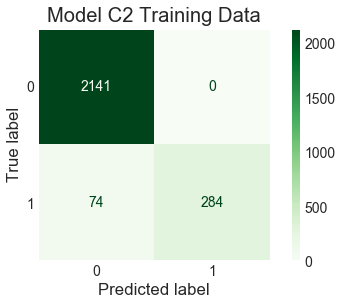

In [130]:
confusion_matrix(forest_2, features_train, y_train, 'Model C2 Training Data')

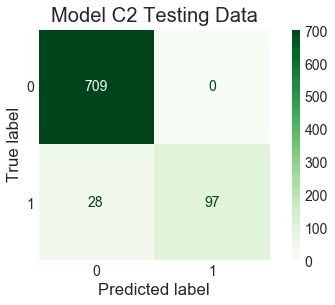

In [131]:
confusion_matrix(forest_2, features_test, y_test, 'Model C2 Testing Data')

In [132]:
# Model C2 training data classification report
classification(y_train, forest_2, features_train_df)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2141
           1       1.00      0.79      0.88       358

    accuracy                           0.97      2499
   macro avg       0.98      0.90      0.93      2499
weighted avg       0.97      0.97      0.97      2499



In [133]:
# Model C2 testing data classification report
classification(y_test, forest_2, features_test_df)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       709
           1       1.00      0.78      0.87       125

    accuracy                           0.97       834
   macro avg       0.98      0.89      0.93       834
weighted avg       0.97      0.97      0.96       834



 - According to the testing data classification report Model C2 shows a 100% precision score for true-churn. This would indicate the strongest model based on our main evaluation metric of precision.
 
 
 - Model C does not appear to be overfitting based on the similar results of metrics from the training and testing datasets.

In [134]:
y_pred_c_2 = forest_2.predict(features_test) 

In [135]:
false_positive_rate_c_2, true_positive_rate_c_2, thresholds_c_2 = roc_curve(y_test, y_pred_c_2)
roc_auc_c_2 = auc(false_positive_rate_c_2, true_positive_rate_c_2)
print('\nAUC is :{0}'.format(round(roc_auc_c_2, 2)))


AUC is :0.89


### Model C2 Summary

 - Model C2 top features: 
 - According to Model C2, the top five most imortant features in predicting churn are:
 1. Total Charge
 
 2. Customer Service Calls
 
 3. Total International Minutes
 
 4. International Plan (no)
 
 5. Total Eve Minutes
 
 - Precision Score (test data): 100% (Highest precision score of all models)

 - Area under the curve (test data): 89% (Highest AUC score, tied with Model B2 and Model C)
 
 - Model C2 does not appear to be overfitting based on similar training and testing results.
 
 - Because Model C2 features the highest precision score and AUC (our main evaluation metrics), will use this model as primary model for making business recommendations.

## Models Comparison

In [136]:
data = {'Model Description':['Logistic Regression (Vanilla Model)', 
                             'Logistic Regression (Tuned Parameters & Reduced Features)', 
                             'Decision Tree (Vanilla Model)', 'Decision Tree (Tuned Parameters)', 
                      'Random Forest (Vanilla Model)', 'Random Forest (Tuned Parameters)'],
    'Precision':[.40, .39, .75, .93, .97, 100],
       'AUC':[.84, .84, .88, .89, .89, .89],
        'Feature 1': ['Customer Service Calls', 
                         'Customer Service Calls',
                        'Total Charge',
                        'Total Charge',
                        'Total Charge',
                        'Total Charge'],
        'Feature 2': ['Total Charge', 'Total Charge', 'Customer Service Calls', 'Customer Service calls',
                     'Customer Service Calls', 'Customer Service Calls'],
        'Feature 3': ['International Plan', 'International Plan (no)', 'Number Vmail Messages', 'Voice Mail Plan (no)',
                      'Total International Minutes', 'Total International Minutes'],
        'Notes': ['Low Performing', 'Low Performing', 'Overfitting Model', 'Good Model', 'Overfitting Model', 'Best Model']
       }
model_comparison = pd.DataFrame(data, index=['Model A', 'Model A2', 'Model B', 'Model B2', 'Model C', 'Model C2'])
model_comparison

,Model Description,Precision,AUC,Feature 1,Feature 2,Feature 3,Notes
Model A,Logistic Regression (Vanilla Model),0.40,0.84,Customer Service Calls,Total Charge,International Plan,Low Performing
Model A2,Logistic Regression (Tuned Parameters & Reduce...,0.39,0.84,Customer Service Calls,Total Charge,International Plan (no),Low Performing
Model B,Decision Tree (Vanilla Model),0.75,0.88,Total Charge,Customer Service Calls,Number Vmail Messages,Overfitting Model
Model B2,Decision Tree (Tuned Parameters),0.93,0.89,Total Charge,Customer Service calls,Voice Mail Plan (no),Good Model
Model C,Random Forest (Vanilla Model),0.97,0.89,Total Charge,Customer Service Calls,Total International Minutes,Overfitting Model
Model C2,Random Forest (Tuned Parameters),100.00,0.89,Total Charge,Customer Service Calls,Total International Minutes,Best Model


## Conclusion/Business Recommendations

 - Based on the analysis in this notebook I would recommend the following three business strategies to SyriaTel as a way to prevent losing customers to churn in the future.
 
 1. The most imortant factor in losing customers to churn according the analysis is a customer having a high 'Total Charge'. This makes sense as customers who are paying the most would probably become unhappy with their service and seek out an alternative provider. One solution to this could be to monitor customers' accounts and create a promotion or discount for customers with the highest total charge as a way to prevent them from canceling their service due to high costs.
 
 2. The second most important factor in losing customers to churn appears to be Customer Service Calls. The more a customer calls customer service, the more likely they are to cancel their service. One way to prevent this would be to monitor accounts and notice when customer service calls are above average. A promotion or discounted rate could then be offered to these customers in order to prevent them from canceling their service. Another cheaper solution could be to premptively reach out to these customers in order resolve the issue of why they keep calling for help from customer service. Finally a third way to resolve this could be to overall improve the customer service department, thus improving the customer experience and preventing customer service issues before they become a problem.  
 
 3. The third most imortant factor in losing customers to churn appears to be 'Total International Minutes'. The more total international minutes a customer has, the more likely they are to cancel their service. One solution to this could be to offer a better international plan to these customers in order to prevent them from seeking out an alternative provider. A promotion such as this could also potentially persude international customers from other service providers to switch to SyriaTel, thus increasing the customer base even further.

## Future Work

1. In order to better improve the models, will likely need to to test models on larger customer datasets to see if models remain accurate across a larger customer sample.

2. Could also test models on competitors’ datasets to see if models are similar across different wireless companies.

3. Finally could also build several more unique models as well tuning more model parameters to see if any further conclusions can be reached.